# Quantum Teleportation
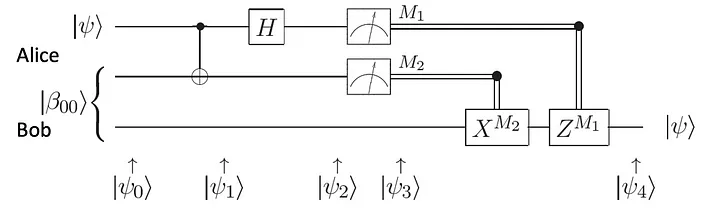
1. Alice starts with 2 qubits — the qubit to teleport ψ, and half of the Bell pair; Bob starts with the other half of the Bell pair. So we are starting off with:
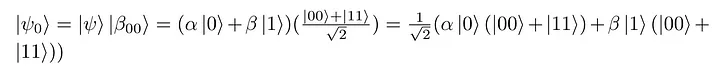
2. Alice does a CNOT on her two qubits, flipping part of her Bell pair:
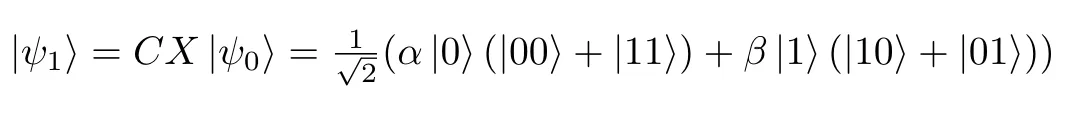
3. After that, she applied the H gate to ψ. Notice she has effectively done the reverse of the process to prepare the Bell pair, we now have the state:
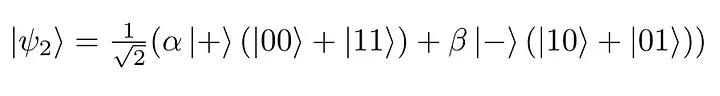
   - This can be re-arranged to:
      
      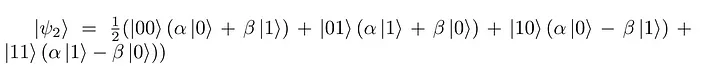
   - and this can be simplified to: 
      
      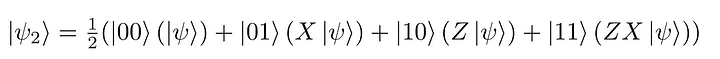
- So the third qubit is in a superposition of different permutations of ψ. Imagine that the qubit was sent in a box and may or may not have flipped over (in either direction). If we open the box the wrong way, we would lose our qubit so it's important that we find out what happened to it on its journey. Fortunately, Alice can tell us. 
- Remember that the first two qubits are Alice’s and the last one is Bob’s. So measuring (the meter sign in the circuit diagram) Alice’s two qubits and getting 00 would mean that Bob now has the original state ψ. But if Alice measures a 1 on her first qubit, then Bob needs to apply a Z gate to recover ψ and if she measures a 1 on her second qubit then Bob must apply an X gate. Unfortunately, this information must be transmitted by classical means. So Alice has to ring Bob up and tell him the results of her measurements — this is what the double lines in the diagram mean. The qubit has been successfully teleported and recovered! Pretty damn cool if you ask me.
- This process is also perfectly secure. As long as Alice and Bob trust each other, Alice can only publish her measurement results when Bob says he’s ready. If Eve the eavesdropper tries to measure the qubit along the way, she won’t know what ‘basis to measure in’ (aka corrections to apply) and doing the wrong one would destroy the qubit.


---

# implementation
- We will use *Qiskit* to simulate the circuit. Qiskit is an open-source python package developed by IBM. It makes the creation and simulation of quantum circuits extremely easy. You can also send your circuits to one of IBM’s 9 publically available quantum computers. 
- Unfortinatly we are not actually going to teleport a qubit very far. The current technology only allows us to run a single circuit on a single quantum computer at any one time and so we will only be teleporting our qubit from the top of the circuit to the bottom. You will have to pretend that Alice and Bob separate themselves after creating their Bell pair.
- A *Quantum Registers* is used to distinguish between Alice's and Bob's Qubits. 

/home/pwnet/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


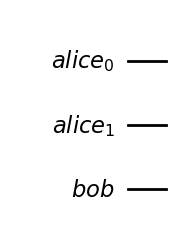

In [6]:
from qiskit import QuantumCircuit, QuantumRegister

# create quantum registers for alice and bob
alice_reg = QuantumRegister(2, 'alice')
bob_reg = QuantumRegister(1, 'bob')
qc = QuantumCircuit(alice_reg, bob_reg)
qc.draw(output='mpl')

# Preparing Bell Pair:
The first step in our protocol is for Alice and Bob to share a Bell pair. To prepare a Bell pair we use the |+> state as a control in a CNOT and 0 as the target. In qiskit, that’s as simple as telling it which operations to apply on which qubits:

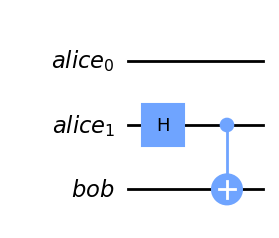

In [7]:
# apply h gate to alice's first qubit
qc.h(alice_reg[1])
# apply cx gate with alice's first qubit as control and bob's qubit as target
qc.cx(alice_reg[1], bob_reg[0])
qc.draw(output='mpl')

# Measuring a Bell pair:
- We know that measuring a Bell pair many times will randomly give 00 and 11, but never anything else. 
- To measure qubits we‘ll create some ClassicalRegisters and add them to the circuit (there are easier ways to do this, but we have to do it this way, for now, to allow the measurement results to be used in the circuit later on).
- Then we can either simulate the circuit or run it on a real device.

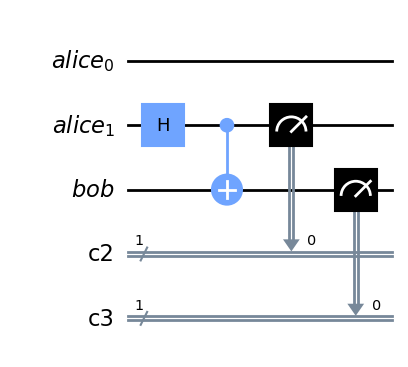

In [8]:
from qiskit import ClassicalRegister
alice_bell_class_reg = ClassicalRegister(1)
qc.add_register(alice_bell_class_reg)
bob_class_reg = ClassicalRegister(1)
qc.add_register(bob_class_reg)
# measure alice's qubit
qc.measure(alice_reg[1], alice_bell_class_reg[0])
# measure bob's qubit
qc.measure(bob_reg[0], bob_class_reg[0])
qc.draw(output='mpl')

In [9]:
# simulate the circuit
from qiskit import Aer, execute 
backend = Aer.get_backend('qasm_simulator') # this is the simulator we'll use
job = execute(qc, backend, shots=1024) # this similate the circuit 1024 times
result = job.result() # get the results
counts = result.get_counts() 
counts

{'0 0': 493, '1 1': 531}

- we notice from the output of the simulatoin that we have roughly random proportions of 00 and 11! *Local Realism*  ... NOT :b.

Now let’s run it on the real thing: 

<span style="background-color: #4c00b0">The first step is to link your IBMQ account with your qiskit
</span>


In [10]:
from qiskit import IBMQ
IBMQ.save_account(open("token1.txt","r").read(), overwrite=True)

<span style="background-color: #4c00b0">You can then see what devices are available for you:

</span>

In [11]:
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q') # Get the provider
provider.backends() # See a list of available backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_kyoto') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_osaka') from IBMQ(hub='ibm-q', group='open', project='main')>]

<span style="background-color: #4c00b0">We can see the same list of devices on the IBM quantum experience website:</span>

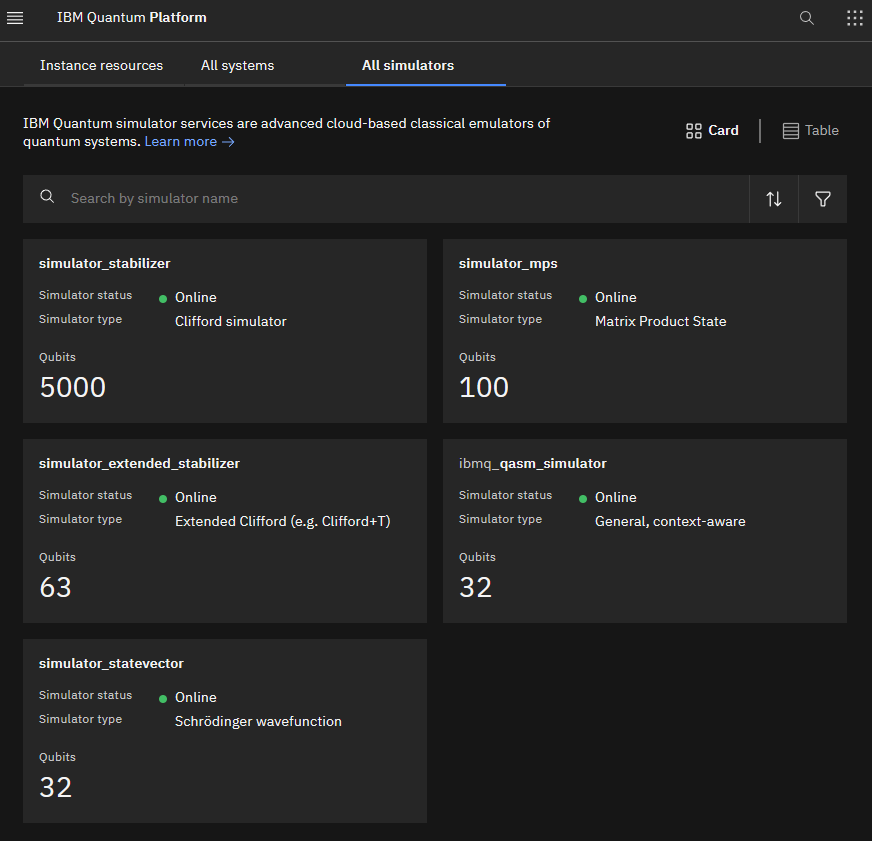

<span style="background-color: #4c00b0">So all we need to do is choose a device and send it off:</span>

In [12]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(simulator=False))
print(backend)
job_exp = execute(qc, backend=backend, shots=1024)
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)

ibm_kyoto
{'1 1': 479, '0 1': 36, '0 0': 498, '1 0': 11}


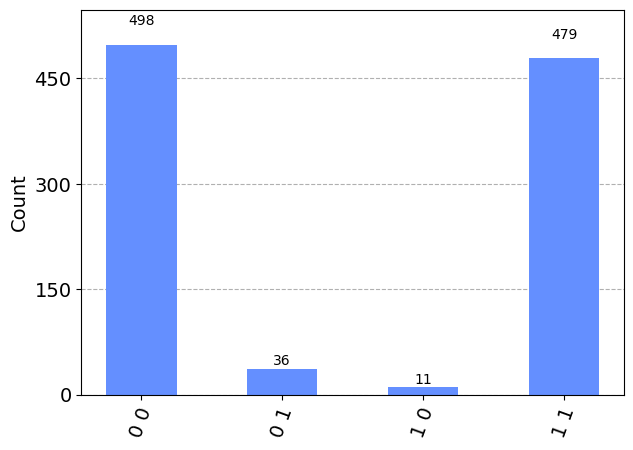

In [13]:
from qiskit.visualization import plot_histogram
plot_histogram(exp_measurement_result)

Why it's not just 00 and 11?
- The rare occurrences of 01 and 10 are, unfortunately, due to errors in the quantum computer. Error rates on quantum computers are still very real problems. You can check the error rates for each simulator on the IBM quantum experience website